<a href="https://colab.research.google.com/github/fidafebin/fida-febin.k/blob/main/Patient's_condition_classification_using_drug_reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd #data preprocessing
import itertools #confusion matrix
import string
import numpy as np
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline
#to show all the rows of pandas dataframe
pd.set_option('display.max_rows',None)

In [ ]:
from google.colab import files
uploaded=files.upload()

Saving drugsCom_raw (1).tsv to drugsCom_raw (1).tsv


In [ ]:
df=pd.read_csv("drugsCom_raw (1).tsv",'\t')

<ipython-input-3-09c54e00b06f>:1: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only.
  df=pd.read_csv("drugsCom_raw (1).tsv",'\t')


In [ ]:
df.head()

,Unnamed: 0,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,"May 20, 2012",27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,"April 27, 2010",192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,"December 14, 2009",17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8.0,"November 3, 2015",10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9.0,"November 27, 2016",37


In [ ]:
df.condition.value_counts()

Birth Control                                                          28788
Depression                                                              9069
Pain                                                                    6145
Anxiety                                                                 5904
Acne                                                                    5588
Bipolar Disorde                                                         4224
Insomnia                                                                3673
Weight Loss                                                             3609
Obesity                                                                 3568
ADHD                                                                    3383
Diabetes, Type 2                                                        2554
Emergency Contraception                                                 2463
High Blood Pressure                                                     2321

In [ ]:
df_train=df[(df['condition']=='Depression')|(df['condition']=='High Blood Pressure')|(df['condition']=='Diabetes, Type 2')]

In [ ]:
df.shape

(161297, 7)

In [ ]:
df_train.shape

(13944, 7)

In [ ]:
X=df_train.drop(['Unnamed: 0','drugName','rating','date','usefulCount'],axis=1)

# EDA

In [ ]:
X.condition.value_counts()

Depression             9069
Diabetes, Type 2       2554
High Blood Pressure    2321
Name: condition, dtype: int64

In [ ]:
X.head()

,condition,review
11,Depression,"""I have taken anti-depressants for years, with..."
31,Depression,"""1 week on Zoloft for anxiety and mood swings...."
44,Depression,"""my gp started me on Venlafaxine yesterday to ..."
50,"Diabetes, Type 2","""Hey Guys, It&#039;s been 4 months since my l..."
67,Depression,"""This medicine saved my life. I was at my wits..."


In [ ]:
# segregating dataframe for analuzing individual condition
X_dep=X[(X['condition']=='Depression')]
X_bp=X[(X['condition']=='High Blood Pressure')]
X_diab=X[(X['condition']=='Diabetes, Type 2')]

In [ ]:
from wordcloud import WordCloud
plt.figure(figsize = (20,20)) # Text that is Fake News Headlines
wc = WordCloud(max_words = 500 , width = 1600 , height = 800).generate(" ".join(X_dep.review))
plt.imshow(wc , interpolation = 'bilinear')
plt.title('Word cloud for Depression',fontsize=14)

Text(0.5, 1.0, 'Word cloud for Depression')

In [ ]:
plt.figure(figsize = (20,20)) # Text that is Fake News Headlines
wc = WordCloud(max_words = 500 , width = 1600 , height = 800).generate(" ".join(X_bp.review))
plt.imshow(wc , interpolation = 'bilinear')
plt.title('Word cloud for High Blood Pressure',fontsize=14)

Text(0.5, 1.0, 'Word cloud for Diabetes Type 2')

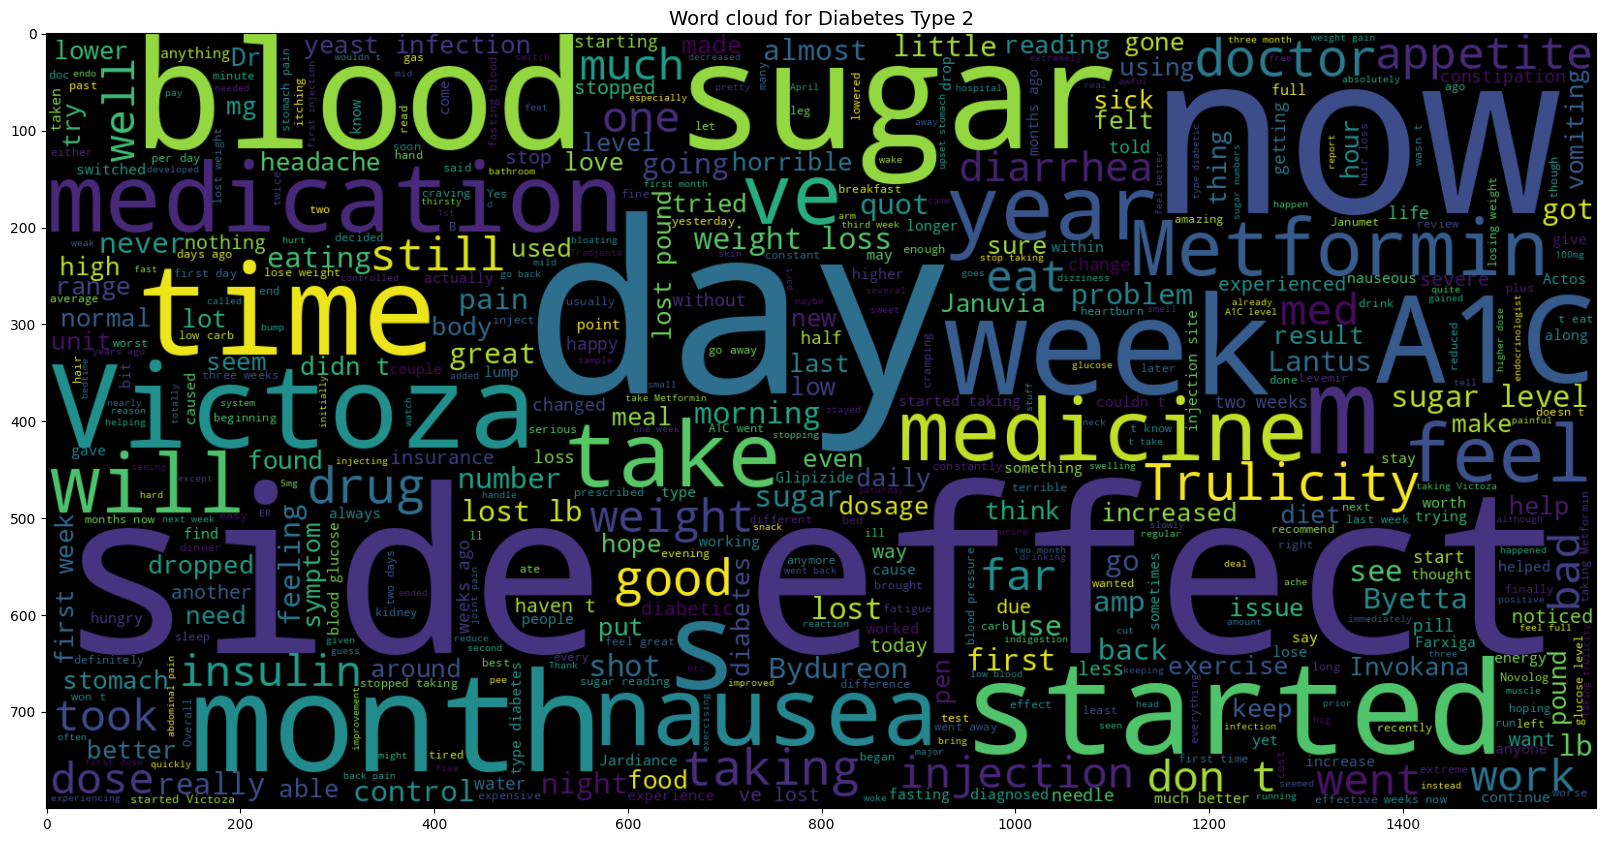

In [ ]:
plt.figure(figsize = (20,20)) # Text that is Fake News Headlines
wc = WordCloud(max_words = 500 , width = 1600 , height = 800).generate(" ".join(X_diab.review))
plt.imshow(wc , interpolation = 'bilinear')
plt.title('Word cloud for Diabetes Type 2',fontsize=14)

##Data Preprocessing

In [ ]:
X['review'][2]

KeyError: ignored

In [ ]:
X['review'][11]

'"I have taken anti-depressants for years, with some improvement but mostly moderate to severe side affects, which makes me go off them.\r\n\r\nI only take Cymbalta now mostly for pain.\r\n\r\nWhen I began Deplin, I noticed a major improvement overnight. More energy, better disposition, and no sinking to the low lows of major depression. I have been taking it for about 3 months now and feel like a normal person for the first time ever. Best thing, no side effects."'

In [ ]:
for i, col in enumerate(X.columns):
    X.iloc[:, i] = X.iloc[:, i].str.replace('"', '')

In [ ]:
# To set the width of the column to maximum
pd.set_option('max_colwidth', -1)

<ipython-input-23-a7edaab304c3>:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('max_colwidth', -1)


In [ ]:
X.head()

,condition,review
11,Depression,"I have taken anti-depressants for years, with some improvement but mostly moderate to severe side affects, which makes me go off them.\r\n\r\nI only take Cymbalta now mostly for pain.\r\n\r\nWhen I began Deplin, I noticed a major improvement overnight. More energy, better disposition, and no sinking to the low lows of major depression. I have been taking it for about 3 months now and feel like a normal person for the first time ever. Best thing, no side effects."
31,Depression,1 week on Zoloft for anxiety and mood swings. I take 50mg in the mornings with my breakfast. Nausea on day one but that subsided as the week went on. I get the jitters about 2 hrs after taking it followed by yawning. I feel much better though and less angry/stressed.
44,Depression,"my gp started me on Venlafaxine yesterday to help with depression and the change,a hour after taking them i was feeling very sick couldn,t stomach food or fluids, thought keep it up as she told me they did come with some side effects which would get better,took another one last night and was so ill i couldn,t stand ,being sick sweating shaking thought i was going to pass out. Did get some sleep hopeing to feel better this morning,took another one and felt so spaced out dry mouth shaking ,sick, so booked in to see gp again to make sure i should be feeling like this, only to find out she had put me on the wrong dose should have been on 37.5mg was put on 150mg, now on right dose hope this will be better"
50,"Diabetes, Type 2","Hey Guys, It&#039;s been 4 months since my last post as I wanted to give it a few months to see how this was going to work. So, I have been on Trulicity for six months now with Metformin. When I hit the five month period the diarrhea, gas, sulphur belching finally subsided. I now longer have any of those side effects. However, I still haven&#039;t lost any weight at all, but I think that was because when I first started Trulicity I was taking it with Glimepiride and that one has a side effect of weight gain so I think the two meds were fighting each other lol. I have been back on the Metformin with Trulicity for about a week now, so we will see what this does. I was diagnosed as stage 3 chronic kidney disease (CKD 3) so I am watching diet closely."
67,Depression,"This medicine saved my life. I was at my wits end with anti-depressants and was ready to give up. My doctor finally prescribed me this after many failed medications, I am so glad she did. I honestly do not know where I would be without Effexor XR. Side effects were very mild compared to other anti-depressants I tried. I was drowsy for the first couple days, but it was tolerable. I highly recommend this for severe depression. I would also like to mention for people to realize there is light at the end of the tunnel and YOU WILL GET BETTER, and to never give up."


##What are stopwords ?
Stopwords are the most common words in any natural language. For the purpose of building NLP models, these stopwords might not add much value to the meaning of the document.

The most common words used in a text are “the”, “is”, “in”, “for”, “where”, “when”, “to”, “at” etc.

In [ ]:
from nltk.corpus import stopwords

stop = stopwords.words('english')

In [ ]:
stop

##Lemmitization
Lemmatization usually refers to doing things properly with the use of a vocabulary and morphological analysis of words, normally aiming to remove inflectional endings only and to return the base or dictionary form of a word, which is known as the lemma .

In [ ]:
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer

porter = PorterStemmer()

lemmatizer = WordNetLemmatizer()

In [ ]:
print(porter.stem("sportingly"))
print(porter.stem("very"))
print(porter.stem("troubled"))

In [ ]:
print(lemmatizer.lemmatize("sportingly"))
print(lemmatizer.lemmatize("very"))
print(lemmatizer.lemmatize("troubled"))

In [ ]:
from bs4 import BeautifulSoup
import re

In [ ]:
def review_to_words(raw_review):
    # 1. Delete HTML 
    review_text = BeautifulSoup(raw_review, 'html.parser').get_text()
    # 2. Make a space
    letters_only = re.sub('[^a-zA-Z]', ' ', review_text)
    # 3. lower letters
    words = letters_only.lower().split()
    # 5. Stopwords 
    meaningful_words = [w for w in words if not w in stop]
    # 6. lemmitization
    lemmitize_words = [lemmatizer.lemmatize(w) for w in meaningful_words]
    # 7. space join words
    return( ' '.join(lemmitize_words))

In [ ]:
X['review_clean'] = X['review'].apply(review_to_words)

In [ ]:
X.head()

## Creating features and Target Variable

In [ ]:
X_feat=X['review_clean']
y=X['condition']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_feat, y,stratify=y,test_size=0.2, random_state=0)

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    See full source and example: 
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## Bag of Words

In [ ]:
count_vectorizer = CountVectorizer(stop_words='english')

count_train = count_vectorizer.fit_transform(X_train)

count_test = count_vectorizer.transform(X_test)

In [ ]:
count_train

## Machine Learning Model : Naive Bayes

In [ ]:
mnb = MultinomialNB()
mnb.fit(count_train, y_train)
pred = mnb.predict(count_test)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)

cm = metrics.confusion_matrix(y_test, pred, labels=['Depression','Diabetes, Type 2','High Blood Pressure'])
plot_confusion_matrix(cm, classes=['Depression','Diabetes, Type 2','High Blood Pressure'])

## Machine Learning Model : Passive Aggressive Classifier

In [ ]:
from sklearn.linear_model import PassiveAggressiveClassifier,LogisticRegression

passive = PassiveAggressiveClassifier()
passive.fit(count_train, y_train)
pred = passive.predict(count_test)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred, labels=['Depression','Diabetes, Type 2','High Blood Pressure'])
plot_confusion_matrix(cm, classes=['Depression','Diabetes, Type 2','High Blood Pressure'])

## TFIDF

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.8)
tfidf_train_2 = tfidf_vectorizer.fit_transform(X_train)
tfidf_test_2 = tfidf_vectorizer.transform(X_test)

## Machine Learning Model : Naive Bayes

In [ ]:
mnb_tf = MultinomialNB()
mnb_tf.fit(tfidf_train_2, y_train)
pred = mnb_tf.predict(tfidf_test_2)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred, labels=['Depression','Diabetes, Type 2','High Blood Pressure'])
plot_confusion_matrix(cm, classes=['Depression','Diabetes, Type 2','High Blood Pressure'])

## Machine Learning Model TFIDF

In [ ]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.8)
tfidf_train = tfidf_vectorizer.fit_transform(X_train)
tfidf_test = tfidf_vectorizer.transform(X_test)

pass_tf = PassiveAggressiveClassifier()
pass_tf.fit(tfidf_train, y_train)
pred = pass_tf.predict(tfidf_test)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred, labels=['Depression','Diabetes, Type 2','High Blood Pressure'])
plot_confusion_matrix(cm, classes=['Depression','Diabetes, Type 2','High Blood Pressure'])

## TFIDF: Bigrams

In [ ]:
tfidf_vectorizer2 = TfidfVectorizer(stop_words='english', max_df=0.8, ngram_range=(1,2))
tfidf_train_2 = tfidf_vectorizer2.fit_transform(X_train)
tfidf_test_2 = tfidf_vectorizer2.transform(X_test)

In [ ]:
pass_tf = PassiveAggressiveClassifier()
pass_tf.fit(tfidf_train_2, y_train)
pred = pass_tf.predict(tfidf_test_2)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred, labels=['Depression','Diabetes, Type 2','High Blood Pressure'])
plot_confusion_matrix(cm, classes=['Depression','Diabetes, Type 2','High Blood Pressure'])

## TFIDF : Trigrams

In [ ]:
tfidf_vectorizer3 = TfidfVectorizer(stop_words='english', max_df=0.8, ngram_range=(1,3))
tfidf_train_3 = tfidf_vectorizer3.fit_transform(X_train)
tfidf_test_3 = tfidf_vectorizer3.transform(X_test)

pass_tf = PassiveAggressiveClassifier()
pass_tf.fit(tfidf_train_3, y_train)
pred = pass_tf.predict(tfidf_test_3)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred, labels=['Birth Control', 'Depression','Diabetes, Type 2','High Blood Pressure'])
plot_confusion_matrix(cm, classes=['Birth Control', 'Depression','Diabetes, Type 2','High Blood Pressure'])

## Most important Features

In [ ]:
def most_informative_feature_for_class(vectorizer, classifier, classlabel, n=10):
    labelid = list(classifier.classes_).index(classlabel)
    feature_names = vectorizer.get_feature_names()
    topn = sorted(zip(classifier.coef_[labelid], feature_names))[-n:]

    for coef, feat in topn:
        print (classlabel, feat, coef)

       
       
 most_informative_feature_for_class(tfidf_vectorizer, pass_tf, 'Depression')

In [ ]:
most_informative_feature_for_class(tfidf_vectorizer, pass_tf, 'High Blood Pressure')

In [ ]:
most_informative_feature_for_class(tfidf_vectorizer, pass_tf, 'Diabetes, Type 2')

## Sample Predictions

In [ ]:
X.tail()

In [ ]:
text =["I have only been on Tekturna for 9 days. The effect was immediate. I am also on a calcium channel blocker (Tiazac) and hydrochlorothiazide. I was put on Tekturna because of palpitations experienced with Diovan (ugly drug in my opinion, same company produces both however). The palpitations were pretty bad on Diovan, 24 hour monitor by EKG etc. After a few days of substituting Tekturna for Diovan, there are no more palpitations."]
test = tfidf_vectorizer.transform(text)
pred1=pass_tf.predict(test)[0]
pred1

In [ ]:
text =["This is the third med I&#039;ve tried for anxiety and mild depression. Been on it for a week and I hate it so much. I am so dizzy, I have major diarrhea and feel worse than I started. Contacting my doc in the am and changing asap."]
test = tfidf_vectorizer.transform(text)
pred1=pass_tf.predict(test)[0]
pred1

In [ ]:
text =["I just got diagnosed with type 2. My doctor prescribed Invokana and metformin from the beginning. My sugars went down to normal by the second week. I am losing so much weight. No side effects yet. Miracle medicine for me"]
test = tfidf_vectorizer.transform(text)
pred1=pass_tf.predict(test)[0]
pred1